# Solving Continuous Control Problem by DRL Policy-based Method(DDPG
## "Version 2: Twenty (20) Agents"
---
In this notebook, we will implement a DDPG agent with Unity ML-Agents Reacher("Version 2: Twenty (20) Agents") environment.

### 1. Import the Necessary Packages

In [1]:
import torch
import random
import numpy as np
from collections import deque
from ddpg_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Import the Necesaary Packages to start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

### 3. Instantiate the Environment
Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`("Version 2: Twenty (20) Agents": I renamed it 'Reacher-20Agents.app').  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher-20Agents.app")
```

In [3]:
env = UnityEnvironment(file_name="Reacher-20Agents.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
brain_name

'ReacherBrain'

In [6]:
brain

### 4. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 5. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.08199999816715717


When finished, you can close the environment.

In [ ]:
env.close()

### 6. Train our own Agent with REINFORCE

Now it's our turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [9]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

### Set the Training Parameters

* num_episodes (int): maximum number of training episodes
* episode_scores (float): list to record the scores obtained from each episode
* scores_average_window (int): the window size employed for calculating the average score (e.g. 100)
* solved_score (float): the average score required for the environment to be considered solved


In [10]:
num_episodes=1000
episode_scores = []
scores_average_window = 100      
solved_score = 30   

Before running the next code cell, check yourself with the code in `reinforce_agent.py` and `model.py`.  Once you have an understanding of how the different files work together, 
- Check a neural network architecture in `model.py` that maps states to action values.  This file is to define our own REINFORCE Policy Model!

### Create a DDPG Agent from the Agent Class in ddpg_agent.py

A DDPG agent initialized with the following parameters.

* state_size (int): dimension of each state (required)
* action_size (int): dimension of each action (required)
* num_agents (int): number of agents in the unity environment
* seed (int): random seed for initializing training point (default = 0)

In [11]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

### DDPG Model Architecture 

In [12]:
agent.actor_local

Actor(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)

In [13]:
agent.actor_target

Actor(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)

In [14]:
agent.critic_local

Critic(
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)

In [20]:
agent.critic_target

Critic(
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)

### Chosen Hyperparamters
* BUFFER_SIZE = int(1e5)  # replay buffer size
* BATCH_SIZE = 128        # minibatch size
* GAMMA = 0.99            # discount factor
* TAU = 1e-3              # for soft update of target parameters
* LR_ACTOR = 1e-4         # learning rate of the actor 
* LR_CRITIC = 1e-4        # learning rate of the critic
* WEIGHT_DECAY = 0.0      # L2 weight decay

### Train the Agent with DDPG

Run the code cell below to train the agent from scratch.

In [16]:
def ddpg(n_episodes=1000, print_every=100):
    # loop from n_episodes
    for i_episode in range(1, n_episodes+1):

        # Reset the Unity ML-agents environment at the beginning of each episode
        env_info = env.reset(train_mode=True)[brain_name]     

        # Get initial state of the Unity ML-agents environment 
        states = env_info.vector_observations

        # Reset the training agent for new episode
        agent.reset()

        # Set the initial episode score to zero.
        agent_scores = np.zeros(num_agents)

        # Run the episode training loop;
        # At each loop step take an action as a function of the current state observations
        # Update the Agents Actor and Critic networks, based on the next_state and reward received 
        # If environment episode is done, exit loop...
        # Otherwise repeat until done == true 
        while True:
            # Determine actions for the Unity ML-agents from current sate
            actions = agent.act(states)

            # Send the actions to the Unity ML-agents in the environment and receive environment information
            env_info = env.step(actions)[brain_name]        

            next_states = env_info.vector_observations   # Get the next states for each unity agent in the environment
            rewards = env_info.rewards                   # Get the rewards for each the Unity ML-agent in the environment
            dones = env_info.local_done                  # See if episode has finished for each the Unity ML-agent in the environment

            #Send (S, A, R, S') info to the training agent for Replay Buffer (memory) and network updates
            agent.step(states, actions, rewards, next_states, dones)

            # Set new states to current states for determining next actions
            states = next_states

            # Update episode score for each the Unity ML-agent
            agent_scores += rewards

            # If any the Unity ML-agent indicates that the episode is done, 
            # then exit episode loop, to begin new episode
            if np.any(dones):
                break

        # Add episode score to Scores and...
        # Calculate mean score over last 100 episodes 
        # Mean score is calculated over current episodes until i_episode > 100
        episode_scores.append(np.mean(agent_scores))
        average_score = np.mean(episode_scores[i_episode-min(i_episode,average_score_window):i_episode+1])

        # Print current and average score
        print('\nEpisode {}\tEpisode Score: {:.3f}\tAverage Score: {:.3f}'.format(i_episode, episode_scores[i_episode-1], average_score), end="")

        # Save checkpoint trained Actor and Critic network weights after each episode
        an_filename = "checkpoint_actor_20Agents.pth"
        torch.save(agent.actor_local.state_dict(), an_filename)
        cn_filename = "checkpoint_critic_20Agents.pth"
        torch.save(agent.critic_local.state_dict(), cn_filename)

        # Check to see if the task is solved (i.e,. avearge_score > solved_score over 100 episodes). 
        # If yes, save the network weights and scores and end training.
        if i_episode > 100 and average_score >= solved_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, average_score))
            break
    return episode_scores

scores = ddpg(n_episodes=num_episodes)


Episode 1	Episode Score: 0.556	Average Score: 0.556
Episode 2	Episode Score: 0.659	Average Score: 0.608
Episode 3	Episode Score: 0.668	Average Score: 0.628
Episode 4	Episode Score: 1.100	Average Score: 0.746
Episode 5	Episode Score: 1.164	Average Score: 0.830
Episode 6	Episode Score: 0.997	Average Score: 0.858
Episode 7	Episode Score: 1.215	Average Score: 0.909
Episode 8	Episode Score: 1.455	Average Score: 0.977
Episode 9	Episode Score: 2.210	Average Score: 1.114
Episode 10	Episode Score: 2.379	Average Score: 1.241
Episode 11	Episode Score: 4.431	Average Score: 1.531
Episode 12	Episode Score: 5.883	Average Score: 1.893
Episode 13	Episode Score: 5.879	Average Score: 2.200
Episode 14	Episode Score: 9.674	Average Score: 2.734
Episode 15	Episode Score: 9.985	Average Score: 3.217
Episode 16	Episode Score: 11.097	Average Score: 3.710
Episode 17	Episode Score: 14.262	Average Score: 4.330
Episode 18	Episode Score: 16.355	Average Score: 4.999
Episode 19	Episode Score: 24.494	Average Score: 6.0

### Plot the Scores

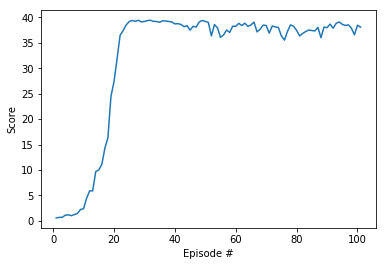

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 7. Watch the DDPG Agent!

In the next code cell, you will load the trained weights from file to watch a the vanilla DDPG Agent!

In [ ]:
# Load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_20Agents.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_20Agents.pth'))

for i_episode in range(1, 3):

    # Reset the unity environment at the beginning of each episode
    # Set train mode to false
    env_info = env.reset(train_mode=False)[brain_name]     

    # Get initial state of the Unity ML-agents environment 
    states = env_info.vector_observations

    # Reset the training agent for new episode
    agent.reset()

    # Set the initial episode scores to zero for each Unity ML-agent.
    scores = np.zeros(num_agents)

    # Run the episode loop;
    # At each loop step take an action as a function of the current state observations
    # If environment episode is done, exit loop...
    # Otherwise repeat until done == true 
    while True:
        # Determine actions for the Unity ML-agents from current sate
        actions = agent.act(states)

        # Send the actions to the Unity ML-agent in the environment and receive environment information
        env_info = env.step(actions)[brain_name]        

        next_states = env_info.vector_observations   # Get the next states for each Unity ML-agent in the environment
        rewards = env_info.rewards                   # Get the rewards for each Unity ML-agent in the environment
        dones = env_info.local_done                  # Gee if episode has finished for each Unity ML-agent in the environment

        # Set new states to current states for determining next actions
        states = next_states

        # Update episode score for each Unity ML-agent
        scores += rewards

        # If any Unity ML-agent indicates that the episode is done, 
        # then exit episode loop, to begin new episode
        if np.any(dones):
            break

    # Print current average score
    print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores), end=""))

In [ ]:
env.close()

## Future Work

### 1. Explore the current DDPG Algorithm

* Amend the various hyperparameters and network architecture to see if we can get your agent to solve the environment faster. 
* Once we build intuition for the hyperparameters that work well with this environment, try solving a different Unity ML-Agents task like [Crawler](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#crawler).

### 2. Explore the other PG Algorithm
* We are interested in implementing a method that will be more stable with this project, so we will explore [this paper "Benchmarking Deep Reinforcement Learning for Continuous Control"](https://arxiv.org/abs/1604.06778)
* We would like to implement some improvements such as ...
    - [Trust Region Policy Optimization (TRPO)](https://arxiv.org/abs/1502.05477)
    - Truncated Natural Policy Gradient (TNPG)
    - [Proximal Policy Optimization (PPO)](https://blog.openai.com/openai-baselines-ppo/)
    - [Distributed Distributional Deterministic Policy Gradients (D4PG) ](https://arxiv.org/abs/1602.01783)

![Performance Comparison](assets/benchmark-DRL-ContinousControl.png)